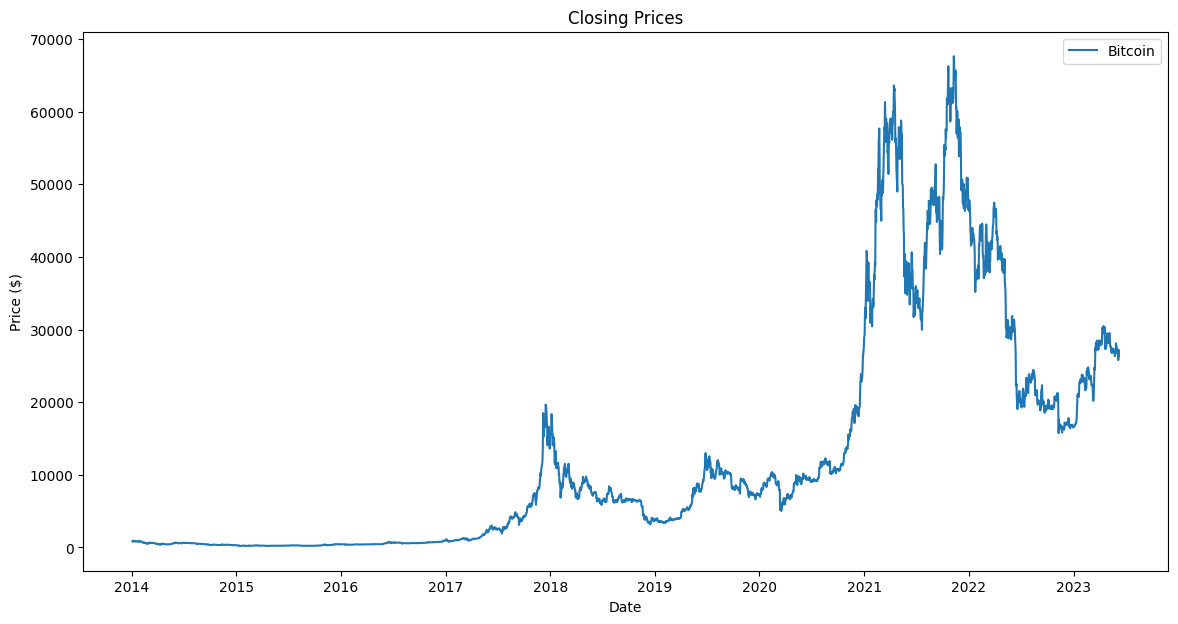

In [107]:
# Cell1: load data
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from datetime import timedelta

btc_data = pd.read_csv('C:/Users/user/Desktop/btc-usd-max.csv', parse_dates=['snapped_at'], index_col='snapped_at')

# Removing our missing data
btc_data = btc_data.iloc[250:]

# Let's see the chart!
plt.figure(figsize=(14, 7))
plt.plot(btc_data['price'], label='Bitcoin')
plt.title('Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

Epoch 1/60
17/17 [==============================] - 6s 73ms/step - loss: 0.0167 - val_loss: 0.0131
Epoch 2/60
17/17 [==============================] - 1s 31ms/step - loss: 0.0086 - val_loss: 0.0072
Epoch 3/60
17/17 [==============================] - 0s 27ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 4/60
17/17 [==============================] - 0s 22ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 5/60
17/17 [==============================] - 0s 23ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/60
17/17 [==============================] - 0s 23ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/60
17/17 [==============================] - 0s 23ms/step - loss: 0.0011 - val_loss: 8.9626e-04
Epoch 8/60
17/17 [==============================] - 0s 23ms/step - loss: 8.2087e-04 - val_loss: 6.8753e-04
Epoch 9/60
17/17 [==============================] - 0s 26ms/step - loss: 7.0275e-04 - val_loss: 5.9006e-04
Epoch 10/60
17/17 [==============================] - 0s 25ms/step - loss: 6.3687e-04 - va

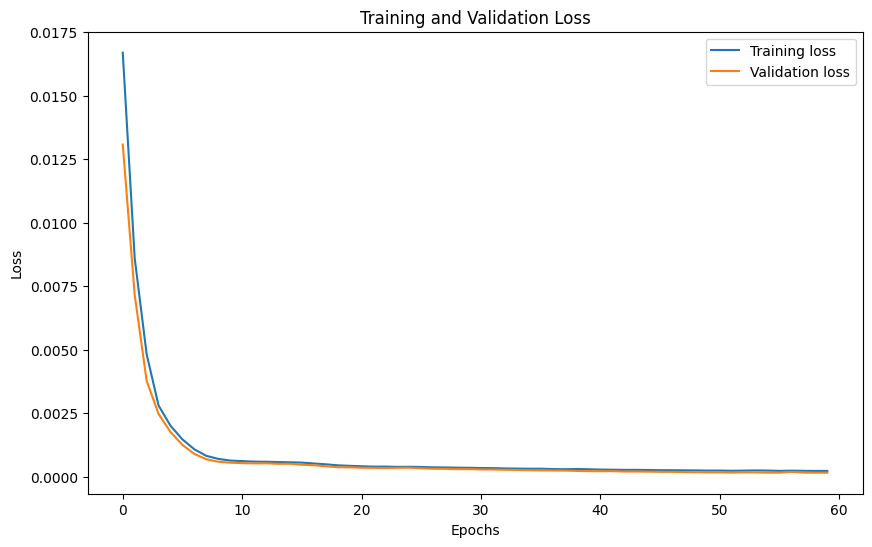

In [108]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import LSTM, Input, Dropout, Dense
import tensorflow as tf

# Function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-2*seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length:i+2*seq_length] - data[i+seq_length-1:i+2*seq_length-1]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)


# Normalizing and sequence creation

sequence_length = 6

# Normalize the price data
scaler_price = MinMaxScaler()
btc_price = scaler_price.fit_transform(np.array(btc_data['price']).reshape(-1, 1))

# Normalize the volume data
scaler_volume = MinMaxScaler()
btc_volume = scaler_volume.fit_transform(np.array(btc_data['total_volume']).reshape(-1, 1))

# Combine the normalized price and volume data
btc_data_normalized = np.hstack((btc_price, btc_volume))

# Cut off the data for the last 2 months
cut_off_date = btc_data.index.max() - pd.DateOffset(months=2)
btc_data_last_two_months = btc_data_normalized[btc_data.index > cut_off_date]
btc_data_normalized = btc_data_normalized[btc_data.index <= cut_off_date]


# Create btc_data for last two months
btc_data_last_two_months = btc_data[btc_data.index > cut_off_date]


# Create sequences
btc_sequences, btc_targets = create_sequences(btc_data_normalized, sequence_length)

# Split the sequences into input (X) and output (y) data
X = btc_sequences
y = btc_targets

# Then do the train/test split on X and y separately
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Split the sequences into training, validation, and test data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

from tensorflow.keras.layers import Add, TimeDistributed

class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # Ensure the output is the same shape as the input.
        output = inputs[:, :, :] + delta
        return output


# Define the LSTM model to be wrapped
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True),  # This LSTM also needs to return sequences.
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2, kernel_initializer=tf.initializers.zeros())),  # Using TimeDistributed to apply the Dense layer to each time step.
])

# Now wrap it
residual_lstm = ResidualWrapper(lstm_model)


# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
residual_lstm.compile(optimizer=optimizer, loss='mse')

# Train
history = residual_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=60,
    verbose=1,
)

# Predict
y_pred = residual_lstm.predict(X_test)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [109]:
# Reshape y_test and y_pred
y_test = y_test.reshape(-1, sequence_length, 2)
y_pred = y_pred.reshape(-1, sequence_length, 2)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
mse = mean_squared_error(y_test.flatten(), y_pred.flatten())
rmse = np.sqrt(mse)

# Print evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 0.015952352422418173
Mean Squared Error (MSE): 0.0005479996517093099
Root Mean Squared Error (RMSE): 0.023409392382317613


In [122]:
# Swing Trading
btc_held = 0
portfolio = 10000  # Initial portfolio value
btc_amount = 0
trade_type = None
profit_or_loss = 0
FFPS_ratio = 0.02  

# Create a new dataframe based on last two months
btc_data_last_two_months = btc_data[-60:].copy()
btc_data_last_two_months['SMA_30'] = btc_data_last_two_months['price'].rolling(window=30).mean()

trades = pd.DataFrame(columns=['portfolio_value', 'trade_type'])

# Loop through the data for the last two months
for i in range(30, len(btc_data_last_two_months)):  # Start from 30 because we now have SMA_30
    signal = np.sign(btc_data_last_two_months['price'].iloc[i] - btc_data_last_two_months['SMA_30'].iloc[i])

    if signal == 1 and btc_held == 0:  # Buy signal
        spend = FFPS_ratio * portfolio
        btc_amount = spend / btc_data_last_two_months['price'].iloc[i]
        portfolio -= spend
        btc_held += btc_amount
        trade_type = 'Buy'
        trades = pd.concat([trades, pd.DataFrame({'portfolio_value': [portfolio], 'trade_type': [trade_type]})],
                           ignore_index=True)

    elif signal == -1 and btc_held > 0:  # Sell signal
        btc_amount = btc_held
        spend = btc_amount * btc_data_last_two_months['price'].iloc[i]
        portfolio += spend
        btc_held = 0
        trade_type = 'Sell'
        trades = pd.concat([trades, pd.DataFrame({'portfolio_value': [portfolio], 'trade_type': [trade_type]})],
                           ignore_index=True)

    if i > 30 and trade_type == 'Sell':
        profit_or_loss = portfolio - trades['portfolio_value'].iloc[-2] if len(trades) > 0 else 0
    else:
        profit_or_loss = 0

print("Initial Portfolio Value:", 10000)
print("Final Portfolio Value:", portfolio)



Initial Portfolio Value: 10000
Final Portfolio Value: 9987.454876264064
